In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import bs4 as bs
import requests


Bad key "text.kerning_factor" on line 4 in
C:\Users\amuni\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
plt.style.use('fivethirtyeight')

In [3]:
import bs4 as bs
import requests
import yfinance as yf
import datetime

resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '') for s in tickers]
start = datetime.datetime(2020,1,1)
end = datetime.datetime(2020,6,30)
data = yf.download(tickers, start=start, end=end)

[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


In [4]:
#Slice Open Prices
sp500_open=data.iloc[:, data.columns.get_level_values(0)=='Open']
sp500_open.head()
#Slice Adj. Close Prices
sp500_adjclose=data.iloc[:, data.columns.get_level_values(0)=='Adj Close']
sp500_adjclose.head()

Adj Close                                                          \
                    A        AAL         AAP       AAPL       ABBV        ABC   
Date                                                                            
2020-01-02  85.552170  28.982893  158.154831  74.573036  86.008141  83.938957   
2020-01-03  84.178558  27.548195  158.164749  73.848030  85.191757  82.883308   
2020-01-06  84.427406  27.219410  155.565384  74.436470  85.864067  84.096809   
2020-01-07  84.686203  27.119778  153.720047  74.086395  85.374245  83.494980   
2020-01-08  85.522316  27.737495  151.954056  75.278160  85.979324  84.303986   

                                                           ...              \
                  ABMD        ABT         ACN        ADBE  ...        XLNX   
Date                                                       ...               
2020-01-02  168.809998  85.885757  207.639603  334.429993  ...  100.399811   
2020-01-03  166.820007  84.838737  207.293793  331.809998  ...   98.088585   
2020-01-06  179.039993  85.283234  205.940170  333.709991  ...   96.044044   
2020-01-07  180.350006  84.809113  201.493912  333.390015  ...   98.236748   
2020-01-08  178.690002  85.154816  201.889160  337.869995  ...   97.960182   

                                                                    \
                  XOM       XRAY        XRX        XYL         YUM   
Date                                                                 
2020-01-02  67.240555  56.634895  35.855373  79.031929  100.691872   
2020-01-03  66.699974  56.008160  35.389343  79.497108  100.376495   
2020-01-06  67.212105  56.316555  34.855347  78.982445  100.317375   
2020-01-07  66.662033  56.614998  34.903889  78.685516  100.494774   
2020-01-08  65.656754  57.211887  34.884472  78.952736  100.672165   

                                                           
                   ZBH        ZBRA       ZION         ZTS  
Date                                                       
2020-01-02  148.520401  259.140015  50.968010  133.542831  
2020-01-03  148.132172  256.049988  50.248787  133.562759  
2020-01-06  147.276093  258.010010  49.636467  132.537338  
2020-01-07  147.146683  256.470001  49.335167  132.985321  
2020-01-08  148.908630  247.639999  49.821129  132.696609  

[5 rows x 505 columns]

In [5]:
# Scrap sp500 tickers
def save_sp500_tickers():

    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'html')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        if not '.' in ticker:
            tickers.append(ticker.replace('\n',''))
        
    return tickers

tickers = save_sp500_tickers()

In [6]:
prices = yf.download(tickers, start='2020-01-01')['Adj Close'] 

[*********************100%***********************]  503 of 503 completed


In [7]:
rs = sp500_adjclose.apply(np.log).diff(1)

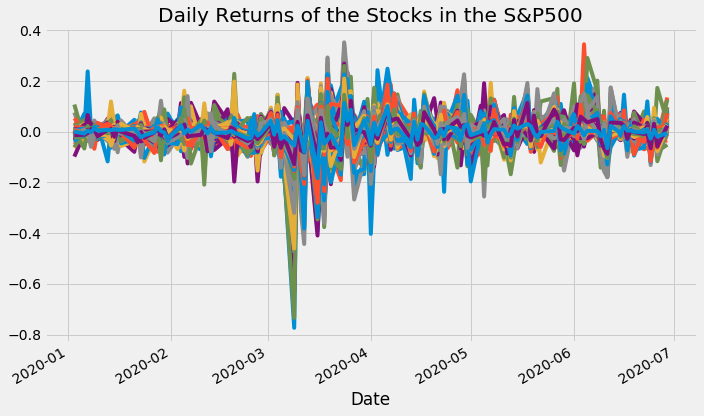

In [8]:
rs.plot(legend=0, figsize=(10,6), grid=True, title='Daily Returns of the Stocks in the S&P500')
plt.tight_layout()
plt.savefig('tmp.png')

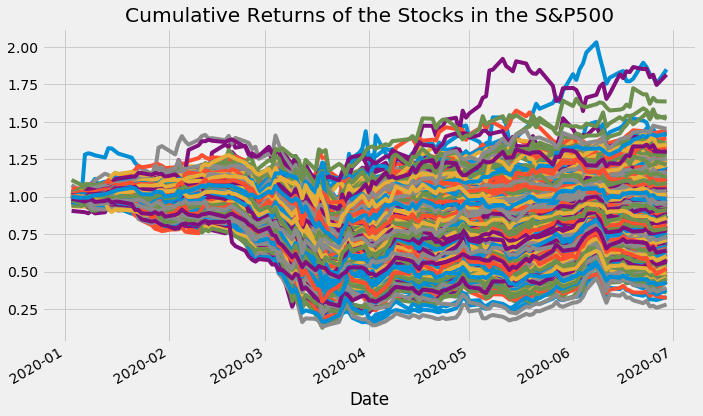

In [9]:
(rs.cumsum().apply(np.exp)).plot(legend=0, figsize=(10,6), grid=True, title='Cumulative Returns of the Stocks in the S&P500')
plt.tight_layout()
plt.savefig('tmp.png')

In [10]:
from sklearn.decomposition import PCA

In [11]:
pca = PCA(1).fit(rs.fillna(0))

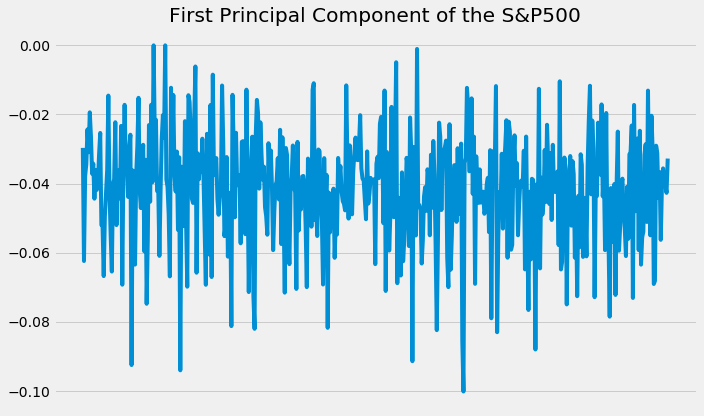

In [12]:
pc1 = pd.Series(index=rs.columns, data=pca.components_[0])

pc1.plot(figsize=(10,6), xticks=[], grid=True, title='First Principal Component of the S&P500')
plt.tight_layout()
plt.savefig('tmp.png')

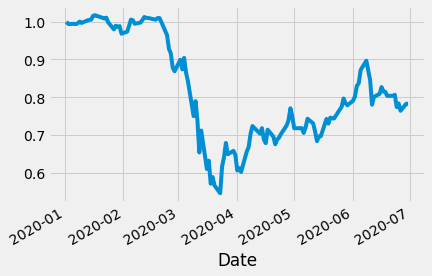

In [13]:
weights = abs(pc1)/sum(abs(pc1))
myrs = (weights*rs).sum(1)
myrs.cumsum().apply(np.exp).plot()

In [14]:
prices = yf.download(['SPY'], start=start, end=end)['Adj Close'] 

[*********************100%***********************]  1 of 1 completed


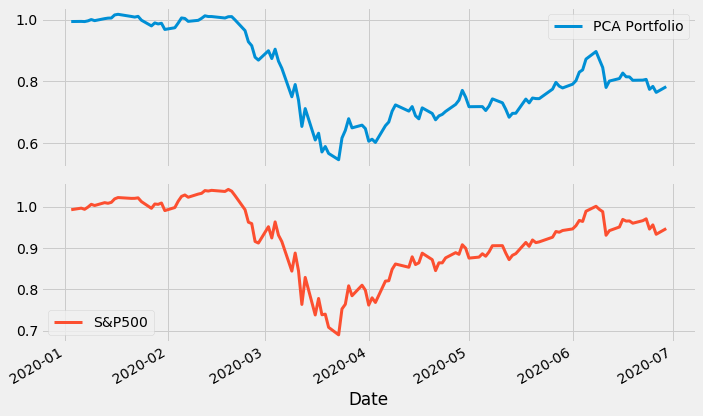

In [15]:
rs_df = pd.concat([myrs, prices.apply(np.log).diff(1)], 1)
rs_df.columns = ["PCA Portfolio", "S&P500"]

rs_df.dropna().cumsum().apply(np.exp).plot(subplots=True, figsize=(10,6), grid=True, linewidth=3);
plt.tight_layout()
plt.savefig('tmp.png')

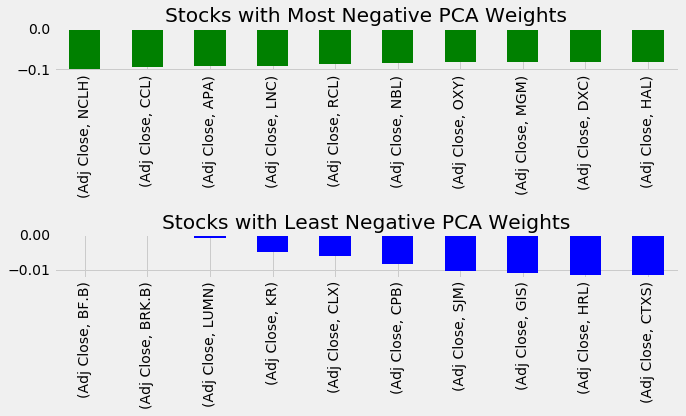

In [16]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
pc1.nsmallest(10).plot.bar(ax=ax[0], color='green', grid=True, title='Stocks with Most Negative PCA Weights')
pc1.nlargest(10).plot.bar(ax=ax[1], color='blue', grid=True, title='Stocks with Least Negative PCA Weights')

plt.tight_layout()
plt.savefig('tmp.png')

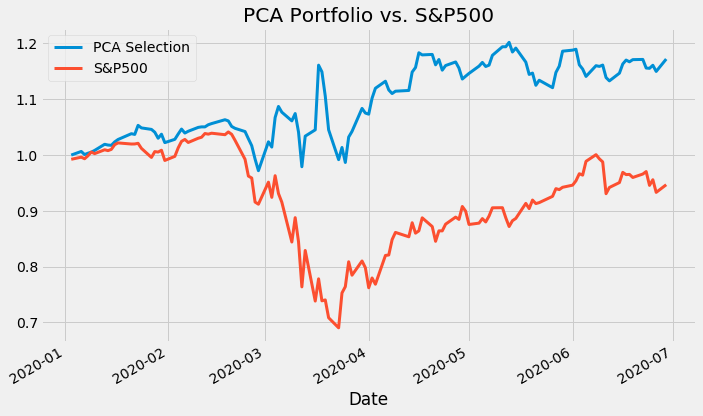

In [17]:
# ws = [-1,]*10+[1,]*10
# myrs = (rs[list(pc1.nsmallest(10).index)+list(pc1.nlargest(10).index)]*ws).mean(1)
myrs = rs[pc1.nlargest(10).index].mean(1)
myrs.cumsum().apply(np.exp).plot(figsize=(15,5), grid=True, linewidth=3, title='PCA Portfolio vs. S&P500')
prices['2020':].apply(np.log).diff(1).cumsum().apply(np.exp).plot(figsize=(10,6), grid=True, linewidth=3)
plt.legend(['PCA Selection', 'S&P500'])

plt.tight_layout()
plt.savefig('tmp.png')

In [18]:
covid_start='2020-03-01'
covid_end='2020-06-30'
data_covid = yf.download(tickers, start=covid_start, end=covid_end)

[*********************100%***********************]  503 of 503 completed


In [19]:
data_covid.

SyntaxError: invalid syntax (<ipython-input-19-816b484c4513>, line 1)